In [1]:
import torch
import matplotlib.pyplot as plt
import glob
import cv2

from src.hog.hog import test_hog, load_hog
from src.hog.hog_op import compute_hog_character

from src.utils.load_data import get_test_data
from src.utils.char_to_int import convert_int_to_char, convert_char_to_int

from src.nn.model import CaptchaClassifierBigger

In [2]:
X_test, y_test = get_test_data()

test_images_ground_truth_files = sorted(glob.glob('./dados/teste/*.jpg'))
test_images_ground_truth = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in test_images_ground_truth_files ]

test_label_files = sorted(glob.glob('./dados/labels10k/*.txt'))[9000:]
test_labels = [open(label_file).read().strip() for label_file in test_label_files]

In [3]:
hog_classifier_path = 'models/captcha_classifier_hog.pkl'
classifier = load_hog(hog_classifier_path)

accuracy = test_hog(classifier, X_test, y_test)

/home/lorenzo/anaconda3/envs/ecg/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator SVC from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


Accuracy: 93.02%


In [4]:
def results_hog(idx_image):
    offset = 6 * idx_image
    
    plt.figure(figsize=(10, 5))
    plt.imshow(test_images_ground_truth[offset//6], cmap='gray')
    plt.axis('off')
    plt.show()
    
    preds = []
    plt.figure(figsize=(10, 5))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(X_test[i+offset], cmap='gray')
        plt.axis('off')
        
        features = compute_hog_character(X_test[i+offset])
        features = features.reshape(1, -1)
        pred = classifier.predict(features)
        preds.append(pred[0])

    plt.show()
            
    pred_string = ''.join(preds)
    print("Predictions:", pred_string)
    print("Ground Truth label: ", test_labels[offset//6])
    
    num_errors = 0
    for i in range(len(pred_string)):
        if pred_string[i] != test_labels[offset//6][i]:
            num_errors += 1

    if not num_errors:
        print('Acertou todos')
    else:
        print(f'Errou {num_errors} vezes')

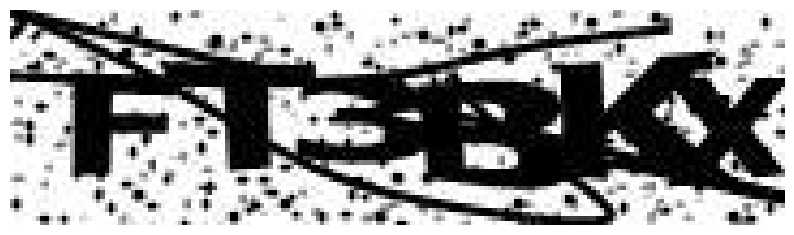

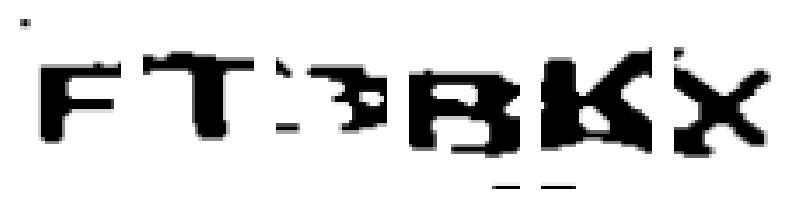

Predictions: FT33KX
Ground Truth label:  FT3BKX
Errou 1 vezes


In [5]:
results_hog(31)

In [6]:
model = CaptchaClassifierBigger()
model.load_state_dict(torch.load('models/nn_model_bigger.pth'))
model.eval()
model.to('cuda')

CaptchaClassifierBigger(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=36, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [7]:
from src.nn.evaluate import evaluate_model
import torch.nn as nn
from torch.utils.data import DataLoader
from src.nn.dataset import TestDataset
criterion = nn.CrossEntropyLoss()

test_dataset = TestDataset()
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

evaluate_model(model, test_loader, criterion)

Test Loss: 0.1356, Test Accuracy: 96.45%


In [8]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def results_nn(idx_image):
    offset = 6 * idx_image
    
    plt.figure(figsize=(10, 5))
    plt.imshow(test_images_ground_truth[offset//6], cmap='gray')
    plt.axis('off')
    plt.show()
    
    preds = []
    plt.figure(figsize=(10, 5))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(X_test[i+offset], cmap='gray')
        plt.axis('off')
        
        with torch.no_grad():
            tensor = transform(X_test[i+offset]).to('cuda')
            outputs = model(tensor.unsqueeze(0))
            _, pred = torch.max(outputs, 1)
            char_pred = convert_int_to_char(int(pred))
            preds.append(char_pred)

    plt.show()
            
    pred_string = ''.join(preds)
    print("Predictions:", pred_string)
    print("Ground Truth label: ", test_labels[offset//6])
    
    conversions = []
    for i in range(6):
        conversions.append(convert_int_to_char(convert_char_to_int(test_labels[offset//6][i])))
        
    print(conversions)
    
    num_errors = 0
    for i in range(len(pred_string)):
        if pred_string[i] != test_labels[offset//6][i]:
            num_errors += 1

    if not num_errors:
        print('Acertou todos')
    else:
        print(f'Errou {num_errors} vezes')

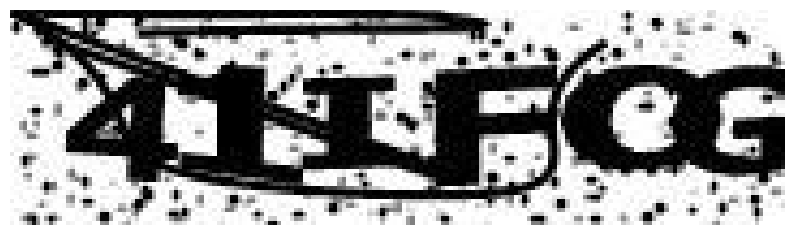

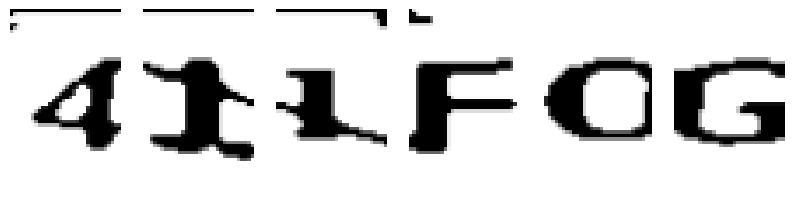

Predictions: 41IFOG
Ground Truth label:  41IFOG
['4', '1', 'I', 'F', 'O', 'G']
Acertou todos


In [13]:
results_nn(252)